# Introduction

Following is the dataset description copied from the [Kaggle page](https://www.kaggle.com/mashlyn/online-retail-ii-uci).

*This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.*

**Attribute Information:**

- `InvoiceNo`: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- `StockCode`: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- `Description`: Product (item) name. Nominal.
- `Quantity`: The quantities of each product (item) per transaction. Numeric.
- `InvoiceDate`: Invice date and time. Numeric. The day and time when a transaction was generated.
- `UnitPrice`: Unit price. Numeric. Product price per unit in sterling (Â£).
- `CustomerID`: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- `Country`: Country name. Nominal. The name of the country where a customer resides.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_context('talk')

# Data Preparation

There are 1,067,371 records with eight columns. There are null values on `Description` and `Customer ID` columns.

In [2]:
df_raw = pd.read_csv("online_retail_II.csv")
df_raw.shape

(1067371, 8)

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Before performing further analysis, we should determine the correct data type of the columns. For instance, `Customer ID` shouldn't be treated as numeric values.

We also create a new column called `subtotal`, which is the multiplication between `Quantity` and the unit price (`Price`).

In [4]:
df_raw['Customer ID'] = df_raw['Customer ID'].astype(str).apply(lambda x: x.split('.')[0])
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
df_raw['subtotal'] = df_raw['Quantity'] * df_raw['Price']

Each record stores a pair of Invoice ID and a purchased item. Thus, there could be multiple records for one invoice.

In [5]:
df_raw.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,subtotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


# Exploratory Analysis

The dataset is not clean; we have negative values in `Quantity` and `Price`.

In [6]:
df_raw.describe()

,Quantity,Price,subtotal
count,1.067371e+06,1.067371e+06,1.067371e+06
mean,9.938898e+00,4.649388e+00,1.806987e+01
std,1.727058e+02,1.235531e+02,2.924202e+02
min,-8.099500e+04,-5.359436e+04,-1.684696e+05
25%,1.000000e+00,1.250000e+00,3.750000e+00
50%,3.000000e+00,2.100000e+00,9.900000e+00
75%,1.000000e+01,4.150000e+00,1.770000e+01
max,8.099500e+04,3.897000e+04,1.684696e+05


## Sales Volume

> Assumption: **sales volume = quantity**

The daily sales volume plot shows a fluctuation in the sales, which could be attributed to daily seasonality. On the weekly plot, we observe a sales decline in January (both 2010 and 2011). The 2011's January decline is steeper than 2010's. 

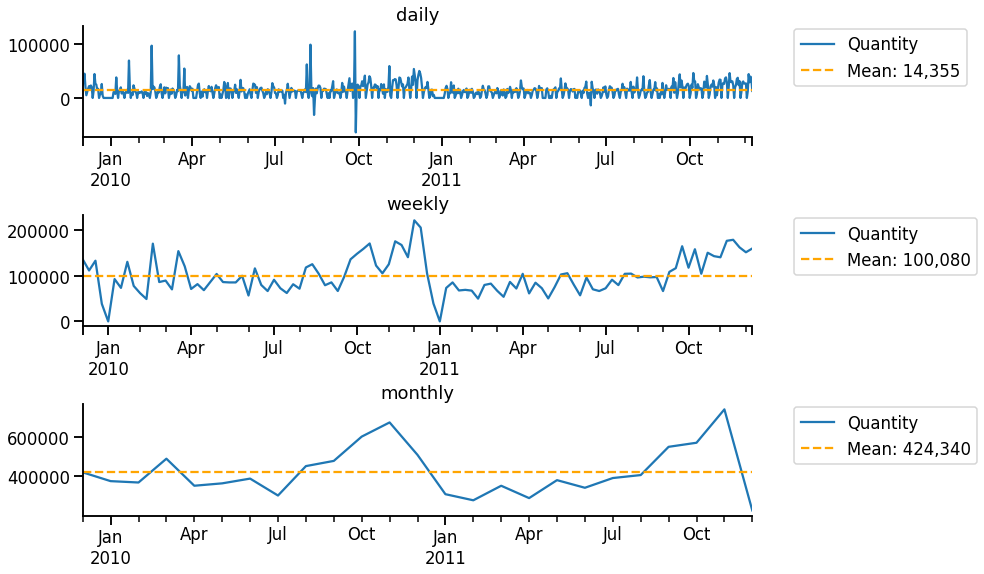

In [7]:
f, ax = plt.subplots(figsize = (12, 9), nrows = 3)
plt.subplots_adjust(hspace = .7)

sales_volume_col = 'Quantity'
titles = ['daily','weekly','monthly']
agg = {}

for i, grp in enumerate(['1D','1W','1M']):
    agg[titles[i]] = df_raw.groupby([
        pd.Grouper(key = 'InvoiceDate', freq = grp)
    ]).agg({sales_volume_col: 'sum'})
    
    agg[titles[i]].plot(ax = ax[i]);
    ax[i].axhline(agg[titles[i]][sales_volume_col].mean(), 
                  linestyle = 'dashed',
                  label = 'Mean: {:,.0f}'.format(agg[titles[i]][sales_volume_col].mean()),
                  color = 'orange');
    
    ax[i].set_xlabel('');
    ax[i].set_title(titles[i]);
    ax[i].legend(bbox_to_anchor = [1.05, 1.05]);
    
sns.despine();
plt.show();

## Last Month's Revenue Share by Product and Customer

> Assumption: **last month = full days of November 2011**

### Based on Product

Following figure shows the top 15 products that contribute the most to revenue in November 2011. Three of them have the highest revenue share.

In [8]:
item_agg_monthly = df_raw.groupby(['StockCode',
               pd.Grouper(key = 'InvoiceDate', freq = '1M')
               ]).agg({
    'subtotal': 'sum',
    'Quantity': 'sum'
}).reset_index()

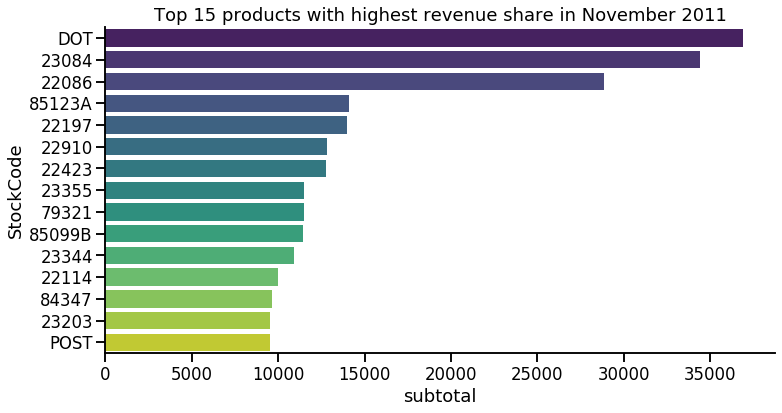

In [9]:
f, ax = plt.subplots(figsize = (12,6))

top_n = 15
mask_item_nov2011 = (item_agg_monthly['InvoiceDate'] == pd.to_datetime('2011-11-30'))
# item_agg_monthly[mask_item_nov2011].sort_values(
#     by = 'subtotal',
#     ascending = False
# ).head(top_n)[['StockCode','subtotal']].plot.barh(ax=ax);

sns.barplot(
    data = item_agg_monthly[mask_item_nov2011].sort_values(
        by = 'subtotal',
        ascending = False
    ).head(top_n),
    x = 'subtotal',
    y = 'StockCode',
    orient = 'h',
    palette = 'viridis'
);

plt.title("Top {} products with highest revenue share in November 2011".format(top_n))
sns.despine();
plt.show();

As a general overview, 578 products (~20% of sold products) contribute to 80% revenue in November 2011; it follows Pareto Principle.

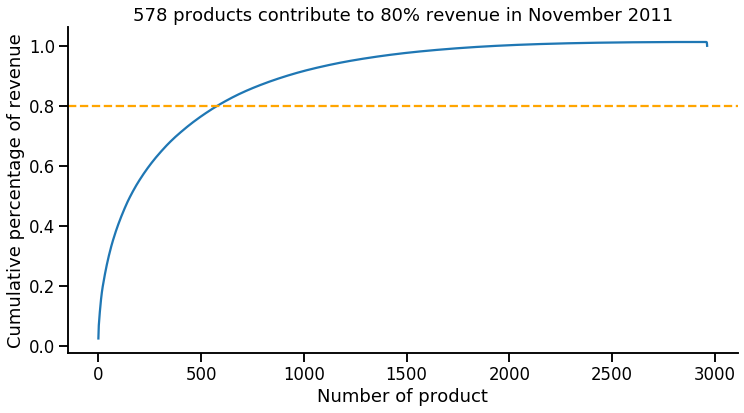

In [10]:
nov_cumulative_pct = item_agg_monthly[mask_item_nov2011]['subtotal'].sort_values(
    ascending = False
).cumsum() / item_agg_monthly[mask_item_nov2011]['subtotal'].sum()
idx_80pct = np.argmin(np.abs(nov_cumulative_pct - 0.8))

f, ax = plt.subplots(figsize = (12,6))
sns.lineplot(
    x = np.arange(len(nov_cumulative_pct)),
    y = nov_cumulative_pct.values,
    ax = ax
)
plt.axhline(y = nov_cumulative_pct.iloc[idx_80pct], linestyle = 'dashed', color = 'orange')

plt.title("{} products contribute to 80% revenue in November 2011".format(idx_80pct))
plt.xlabel("Number of product")
plt.ylabel("Cumulative percentage of revenue")
sns.despine();
plt.show();

As a quick check, most of the top 578 products are sold in each month since December 2009.

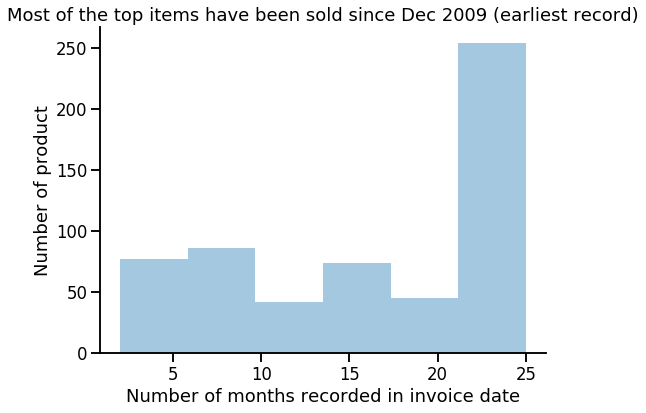

In [11]:
item_agg_all = item_agg_monthly.groupby('StockCode').agg({
    'subtotal': 'sum',
    'Quantity': 'sum',
    'InvoiceDate': 'nunique'
}).reset_index()

nov2011_top_item = item_agg_monthly[mask_item_nov2011].sort_values(by='subtotal', ascending=False).head(idx_80pct)['StockCode'].values
mask_nov2011_top_item = item_agg_all['StockCode'].isin(nov2011_top_item)

f, ax = plt.subplots(figsize = (8, 6))
sns.distplot(
    item_agg_all[mask_nov2011_top_item]['InvoiceDate'],
    kde = False
);

plt.title("Most of the top items have been sold since Dec 2009 (earliest record)")
plt.xlabel("Number of months recorded in invoice date")
plt.ylabel("Number of product")
sns.despine();

### Based on Customer

In November 2011, there is "one" customer that gives a significantly higher revenue share compared to others. However, it comes from invoice with null customer ID. We might need to ignore these customers if we want to perform an analysis on customer-level.

In [12]:
cust_agg_monthly = df_raw.groupby(['Customer ID',
               pd.Grouper(key = 'InvoiceDate', freq = '1M')
               ]).agg({
    'subtotal': 'sum',
    'Quantity': 'sum'
}).reset_index()

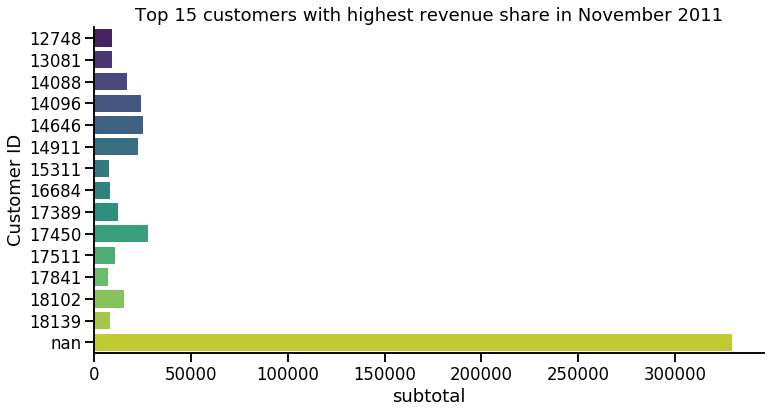

In [13]:
f, ax = plt.subplots(figsize = (12,6))

top_n = 15
mask_cust_nov2011 = (cust_agg_monthly['InvoiceDate'] == pd.to_datetime('2011-11-30'))
sns.barplot(
    data = cust_agg_monthly[mask_cust_nov2011].sort_values(
        by = 'subtotal',
        ascending = False
    ).head(top_n),
    x = 'subtotal',
    y = 'Customer ID',
    hue_order = 'subtotal',
    orient = 'h',
    palette = 'viridis',
    ax = ax
)

plt.title("Top {} customers with highest revenue share in November 2011".format(top_n))
sns.despine();
plt.show();

## Weighted Average Monthly Sales Price by Volume

> Assumption: **weighted avg monthly sales = average product price per month * total quantity per month**

Since the product price range is skewed, we decide to use median to get the average. 
The weighted average shows a similar pattern compared to the actual sales revenue. It gives a higher estimation of the sales, which happens since it is not hugely affected by the negative sales price in the data.

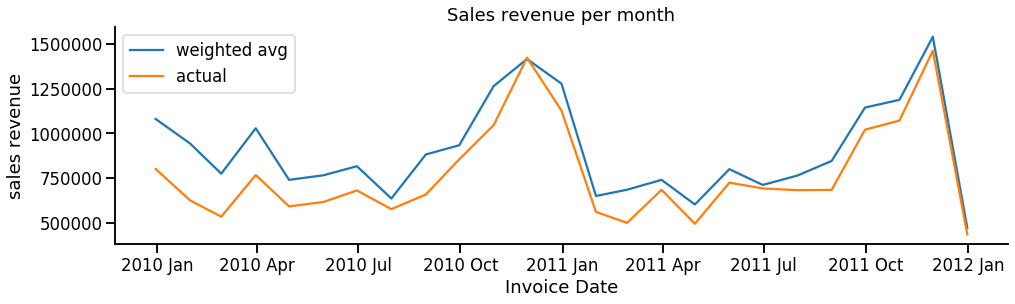

In [14]:
agg_wam = df_raw.groupby(pd.Grouper(key = 'InvoiceDate', freq = '1M')).agg({
    'Price': 'median',
    'Quantity': 'sum',
    'subtotal': 'sum'
}).reset_index()

agg_wam['sales_rev'] = agg_wam['Price'] * agg_wam['Quantity']

f, ax = plt.subplots(figsize = (16,4))

sns.lineplot(
    data = agg_wam,
    x = 'InvoiceDate',
    y = 'sales_rev',
    label = 'weighted avg',
    ax = ax
);

sns.lineplot(
    data = agg_wam,
    x = 'InvoiceDate',
    y = 'subtotal',
    label = 'actual',
    ax = ax
);


ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
sns.despine();
plt.xlabel('Invoice Date')
plt.ylabel('sales revenue')
plt.title('Sales revenue per month');

# Data Cleaning

We observe some records with negative price. Since there are only 5 records, we can remove them.

In [15]:
mask_neg_price = (df_raw['Price'] < 0)
print("Remove {} records with negative price.".format(df_raw[mask_neg_price].shape[0]))

df_raw = df_raw[~mask_neg_price].copy()

Remove 5 records with negative price.


There are more than 22,000 records with negative quantities. It can occur due to sales return or if the products are sold before the data collection date.

Despite the seemingly high number, it only represents 2.15% of our dataset. Moreover, it occurs in most of the months (except in January), with more occurrence around Q4 of the year. Assuming that it is distributed randomly over the period, we ignore these records from our dataset.

In [16]:
mask_neg_qty = (df_raw['Quantity'] < 0)

print("Records with negative quantity: {:,.0f} ~ {:,.2%} of the records.".format(
    df_raw[mask_neg_qty].shape[0],
      df_raw[mask_neg_qty].shape[0] / df_raw.shape[0]
     ))

Records with negative quantity: 22,950 ~ 2.15% of the records.


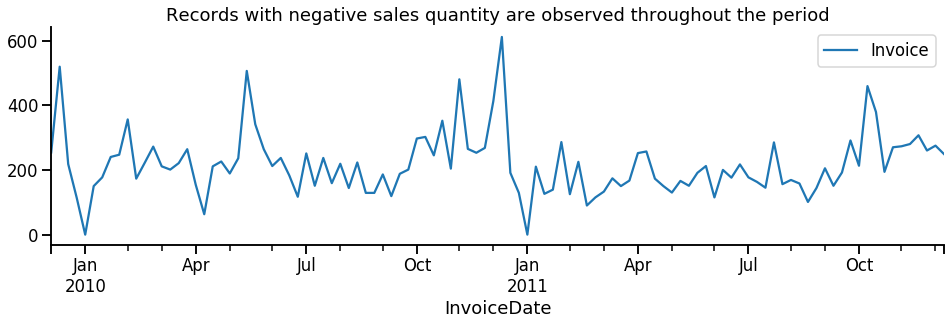

In [17]:
f, ax = plt.subplots(figsize = (16,4))
df_raw[mask_neg_qty].groupby(pd.Grouper(key = 'InvoiceDate', freq = '1W')).agg({
    'Invoice': 'count'
}).plot.line(ax = ax);

sns.despine();
plt.title("Records with negative sales quantity are observed throughout the period");
plt.show();

In [18]:
df_raw = df_raw[~mask_neg_qty].copy()
print("Remaining observations: {:,.0f}".format(df_raw.shape[0]))

Remaining observations: 1,044,416


# Situation Assessment

The owner of the online retailer wants to know how much revenue to expect for this month (December 2011), to help him decide which sports car he buys his partner for Christmas.

To help his decision making, we need a forecast of the sales revenue that can be obtained in December 2011.

There are several things that should be considered in this problem:
1. Which metric should we predict?
    - Our main goal is to predict the sales revenue, but there is an alternative way to achieve that. For instance, we can predict the sales volume. Based on what we observe in our exploratory analysis, we can get a decent estimation of the revenue by multiplying the sales volume with average product price.
    
2. Which level of granularity should we use?
    - In general, we should consider two things: **time** and **unit of interest**. In general, a smaller granularity gives more precise estimation. However, it is costly to do since there is a huge combination of product and customer. As an example, we could one model to forecast whether customer A purchases product X, Y, Z, etc. Meanwhile, if we perform the forecasting in higher level, it is difficult to get a detailed prediction of each product or customer.
    - Time. With our dataset, performing a monthly forecast does not seem to be a good choice since we only have 2 years observations. We might consider using weekly or daily data since it has more observations.
    - Unit of interest
        - Overall: the simplest approach, can be used if we only need a high-level estimate without drilling down on the prediction.
        - Product-based: there are 5,305 products in the dataset. Instead of forecasting the whole product, we can take the top performing product in the previous month, assuming that it will also have high sales in current month.
        - Customer-based: there are 5,943 customers in the dataset. Similar to product's point of view, we can simplify the approach by focusing on customers with highest revenue contribution. However, as we see in the exploratory analysis, it is possible to have missing customer ID. Thus, it is more difficult to get an estimation based on customer level.
        - Product x customer: it gives a more detailed prediction, but we might not consider doing that due to the huge number of possible models required.
        
3. What approach should we use to get the estimated revenue?
    - (Weighted) Moving Average: based on the (weighted) average of historical data. Despite its simplicity, it might not give a good prediction after peak season, e.g., in January, since the forecast is highly influenced by December performance.
    - ARIMA: time series forecasting model, assumes a temporal dependence and stationarity in the data. Although it is a popular time series forecasting method, it requires an extensive parameter tuning to end up with a good prediction. Standard ARIMA method does not allow any regressors in the mathematical model. 
    - Generalised Additive Model: based on regression model, where the time series is decomposed into several components (e.g., trend, seasonality, holiday). Each component contributes to the response variable and has a coefficient value, which helps in model interpretability. This method allows additional regressors in the prediction.
    - Random Forest: based on multiple decision trees, it does not assume temporal dependence in the data. Despite its assumption, ensemble methods like this are frequently found to perform well in forecasting problems, as long as we incorporate temporal characteristics in the feature set.

## Suggested Solution

Based on this short discussion of the approaches, we could perform the forecast using the combination of these options:
1. Metric: 
    - sales revenue
    - sales volume
    
2. Time granularity:
    - weekly
    - daily
    
3. Unit of interest:
    - overall
    - product-based (use top performing products or create the model based on clusters of similar product)
    
4. Algorithm:
    - GAM
    - Random Forest
    
The best approach is to create models in smaller granularity, i.e, product-based on daily basis. This way, we can get a precise prediction, which is more actionable and easier to validate. I suggest using GAM as the model since we can add other variables, such as holiday and number of promotions as additional predictors. Furthermore, it also gives a confidence interval of the prediction, which helps to measure uncertainty during the decision making process. Assuming that the product price is not volatile, we can predict the sales volume in the model, and multiply the predicted volume with the average product price. Models tend to learn more easily when the values are in lower range.

## Implementation

In this work, we attempt to forecast the overall daily sales revenue. In this situation, the retailer owner's just need a rough estimation of the revenue in December to decide his personal decision, which is not related to operational or strategic decision of the retail. Hence, we assume that he does not require a drill-down results of the predicted revenue for each product.

Before we train the model, we split the data into training and validation set. This way, we can get an estimation of model performance before we generate a predicted revenue for December 2011. We use September to November 2011 data as the validation set, while the rest of dataset is used for model training.

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

def mean_absolute_percentage_error1(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_true - y_pred) + 1) /(y_true + 1)) * 100

def evaluate_prediction(y_pred, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = (mean_absolute_error(y_true, y_pred))
    mape = (mean_absolute_percentage_error(y_true, y_pred))
    mape1 = (mean_absolute_percentage_error1(y_true, y_pred))
    print("RMSE\t: {:,.5f}".format(rmse))
    print("MAE\t: {:,.5f}".format(mae))
    print("MAPE\t: {:,.2f}%".format(mape))
    print("MAPE1\t: {:,.2f}%".format(mape1))

In [20]:
df_revenue_daily = df_raw.groupby([
    pd.Grouper(key = 'InvoiceDate', freq = '1D')
]).agg({'subtotal': 'sum'}).reset_index()

df_revenue_daily.columns = ['ds','y']

In [21]:
TEST_START_DT = '2011-09-01'
TEST_END_DT = '2011-12-01'
mask_train = (df_revenue_daily['ds'] < pd.to_datetime(TEST_START_DT))
mask_test = (
    (df_revenue_daily['ds'] >= pd.to_datetime(TEST_START_DT)) & 
    (df_revenue_daily['ds'] < pd.to_datetime(TEST_END_DT))
)

df_train = df_revenue_daily[mask_train].copy()
df_test = df_revenue_daily[mask_test].copy()

### Model training and assessment

In this model, we assume a linear trend on the sales revenue. We incorporate several seasonal components based on our previous exploration: yearly, quarterly, monthly, and weekly.

Although the average error rate in daily basis is 33%, the error cancels each other when we aggregate the results into monthly basis.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE	: 16,322.99480
MAE	: 11,943.93148
MAPE	: 33.86%
MAPE1	: 33.86%


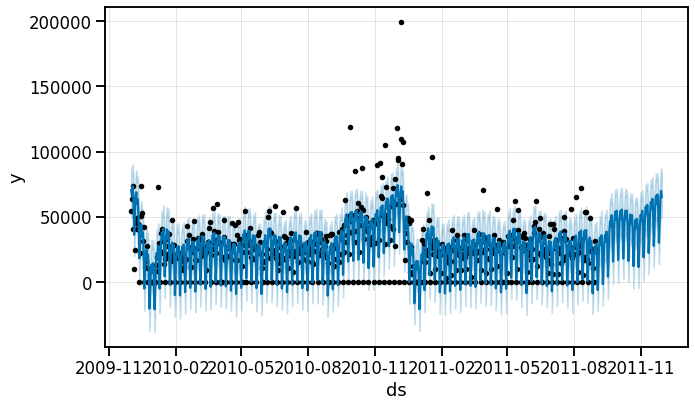

In [24]:
from fbprophet import Prophet

m = Prophet(growth = 'linear', yearly_seasonality = True, weekly_seasonality = True, interval_width = 0.8)
m.add_seasonality(period = 30.4375, fourier_order = 2, name = 'monthly');
m.add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order = 5, prior_scale = 5);
m.fit(df_train);
future = m.make_future_dataframe(periods = df_test.shape[0]);
future = m.predict(future);
m.plot(future);

evaluate_prediction(
    df_test[(df_test['ds'] >= pd.to_datetime(TEST_START_DT))]['y'],
    future[(future['ds'] >= pd.to_datetime(TEST_START_DT))]['yhat']
)

On average, this model has 7.2% error in September to November, with average error of £76,716 per month.

In [25]:
df_test_agg = df_test.groupby(
    pd.Grouper(key = 'ds', freq = '1M')
).agg({'y':'sum'}).reset_index()

df_pred_agg = future[
    (future['ds'] >= pd.to_datetime(TEST_START_DT)) &
    (future['ds'] < pd.to_datetime(TEST_END_DT))
].groupby(
    pd.Grouper(key = 'ds', freq = '1M')
).agg({
    'yhat':'sum',
    'yhat_upper':'sum',
    'yhat_lower':'sum'
}).reset_index()


evaluate_prediction(
    df_test_agg['y'],
    df_pred_agg['yhat']
)

df_pred_agg['actual'] = df_test_agg['y']
df_pred_agg.style.format({
    'yhat': '{:,.0f}',
    'yhat_upper': '{:,.0f}',
    'yhat_lower': '{:,.0f}',
    'actual': '{:,.0f}'
})

RMSE	: 87,348.21926
MAE	: 76,715.80969
MAPE	: 7.20%
MAPE1	: 7.20%


,ds,yhat,yhat_upper,yhat_lower,actual
0,2011-09-30 00:00:00,"931,843","1,448,151","427,534","1,058,590"
1,2011-10-31 00:00:00,"1,233,869","1,754,514","708,870","1,154,979"
2,2011-11-30 00:00:00,"1,534,007","2,041,031","1,023,819","1,509,496"


### Prediction for December 2011

Since we already have data up to December 9, we will predict the revenue for Dec 10 to 31.
This model captures the decreasing trend of sales in the end of year, and results in negative sales. There are two observations of negative values, which we assume as 0 sales.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


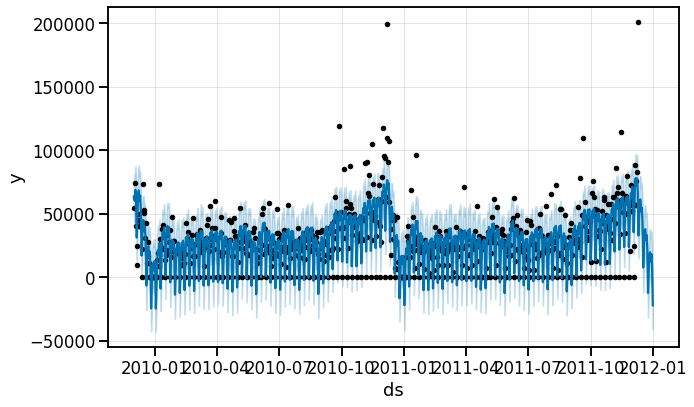

In [26]:
from fbprophet import Prophet

m = Prophet(growth = 'linear', yearly_seasonality = True, weekly_seasonality = True, interval_width = 0.8)
m.add_seasonality(period = 30.4375, fourier_order = 2, name = 'monthly');
m.add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order = 5, prior_scale = 5);
m.fit(df_revenue_daily);
future = m.make_future_dataframe(periods = 22);
future = m.predict(future);
m.plot(future);

In [27]:
mask_unseen = (future['ds'] >= pd.to_datetime('2011-12-10')) & (future['ds'] <= pd.to_datetime('2011-12-31'))

## assume negative prediction as zero
for col in ['yhat','yhat_lower','yhat_upper']:
    future.loc[mask_unseen & (future[col] < 0), col] = 0

We aggregate the daily prediction in Dec 10 to 31 and add them with the observed sales revenue on Dec 1 to 9.

In [28]:
observed_dec2011 = df_revenue_daily[(df_revenue_daily['ds'] >= pd.to_datetime('2011-12-01'))]['y'].sum()
pred_dec1031 = future[mask_unseen].groupby(
    pd.Grouper(key = 'ds', freq = '1M')
).agg({
    'yhat':'sum',
    'yhat_upper':'sum',
    'yhat_lower':'sum'
}).reset_index()

pred_dec1031[['yhat','yhat_upper','yhat_lower']] = pred_dec1031[['yhat','yhat_upper','yhat_lower']] + observed_dec2011

pred_dec1031.style.format({
    'yhat': '{:,.0f}',
    'yhat_upper': '{:,.0f}',
    'yhat_lower': '{:,.0f}'
})

,ds,yhat,yhat_upper,yhat_lower
0,2011-12-31 00:00:00,"1,256,988","1,633,701","934,837"


## Conclusion

In November and December 2010, sales revenue achieved more than £1,000,000. This pattern starts to emerge in November 2011, and our forecast estimates a revenue between £933,568 to £1,631,485, with a point estimate on £1,256,988. Assuming that there is no sudden event, e.g., economic crisis, this forecast should give a reasonable estimation. 

*Should the retail owner buy a new Ferrari?*

Assuming that a new Ferrari costs around $350,000 ~ £264,690 and the revenue achieves £1,000,000 in December 2011, it should be fine if the retail owner purchases it. However, we do not know the condition of this retail, e.g., the monthly fixed cost, whether it is already profitable, etc. Hence, we recommend the retail owner to purchase a new car only if his business is in healthy financial condition.